### Defocused probe ptychography

In this tutorial notebook, we will perform both differential phase contrast (DPC) and ptychographic phase reconstructions from a simulated 4D-STEM dataset.

### Downloads

* [4D-STEM dataset](https://drive.google.com/file/d/1uyeQAQa4DaMwHqN9EHQFCMKAve0_Fgfz/view?usp=share_link)
* [vacuum probe intensity](https://drive.google.com/file/d/1xJgQoxhWMBbtknwRfqB_BkULvgiJe-c1/view?usp=share_link)

### Acknowledgements

This tutorial was created by the py4DSTEM instructor team:
- Colin Ophus (clophus@lbl.gov)
- Stephanie Ribet (sribet@lbl.gov)
- Georgios Varnavides (gvarnavides@berkeley.edu)

The 4D-STEM dataset used here was simulated by Colin Ophus using the reference implementation of partitioned PRISM which can be found at the [Github repo for superPRISM](https://github.com/cophus/superPRISM). We have also added the common experiment artifacts of probe descan which varies over the field of view and shot noise.

Updated 2023 June 17

In [1]:
import numpy as np
import py4DSTEM
print(py4DSTEM.__version__)

0.14.1


In [13]:
file_path = 'data/'
file_data = file_path + 'ptycho_sim_01_data.h5'
file_probe = file_path + 'ptycho_sim_01_probe.h5'

### load the data

In [3]:
dataset = py4DSTEM.read(file_data)
dataset

DataCube( A 4-dimensional array of shape (32, 32, 200, 200) called 'datacube',
          with dimensions:

          Rx = [0,1,...] pixels
          Ry = [0,1,...] pixels
          Qx = [0,1,...] pixels
          Qy = [0,1,...] pixels
)

In [4]:
probe = py4DSTEM.read(file_probe)
probe

DiffractionSlice( A 2-dimensional array of shape (200, 200) called 'diffractionslice',
                  with dimensions:

                  dim0 = [0,1,...] pixels
                  dim1 = [0,1,...] pixels
)

Let's plot some of the probe positions:

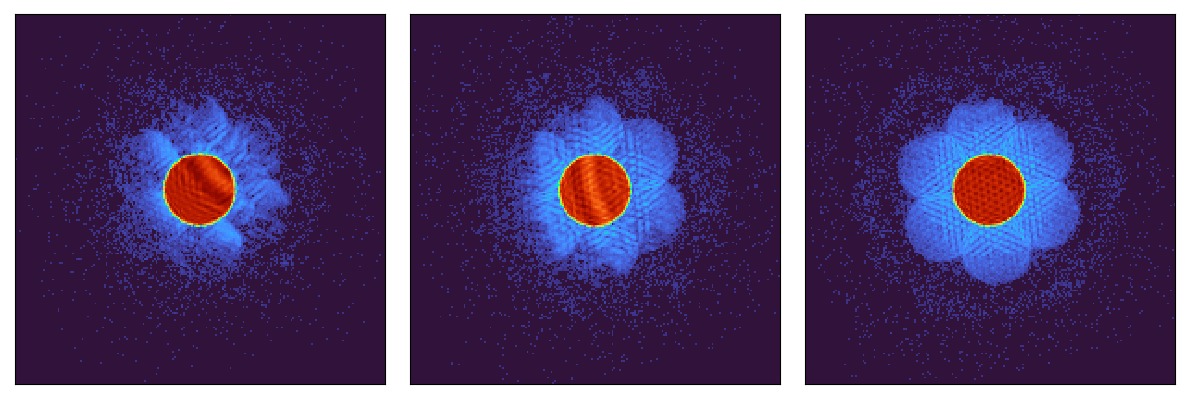

In [6]:
py4DSTEM.show(
    [
        dataset.data[11,24],
        dataset.data[18,24],
        dataset.data[11,12],
    ],
    cmap='turbo',
    vmax=1,
    power=0.333,
    axsize=(4,4),
    ticks=False,
)

### Calibration

We will manually enter the diffraction space sampling and the real space step size between adjacent STEM probes:

In [7]:
dataset.calibration.set_Q_pixel_size(0.025)
dataset.calibration.set_Q_pixel_units('A^-1')
dataset.calibration.set_R_pixel_size(5.0)
dataset.calibration.set_R_pixel_units('A')
dataset.calibration

Calibration( A Metadata instance called 'calibration', containing the following fields:

             Q_pixel_size:    0.025
             R_pixel_size:    5.0
             Q_pixel_units:   A^-1
             R_pixel_units:   A
)

# DPC

First, we perform the preprocessing steps. These include:
1. measuring the center of mass (CoM) for all probe postions.
2. fitting the probe descan to a plane wave or another function.
3. determining the best-fit rotation between real and reciprocal space.
4. calculating the corrected CoM images.

Best fit rotation = -15 degrees.
No need to transpose diffraction intensities.


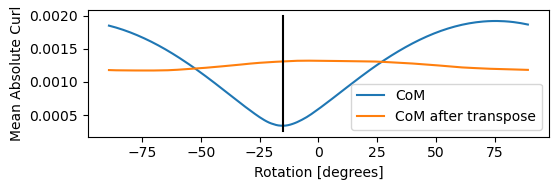

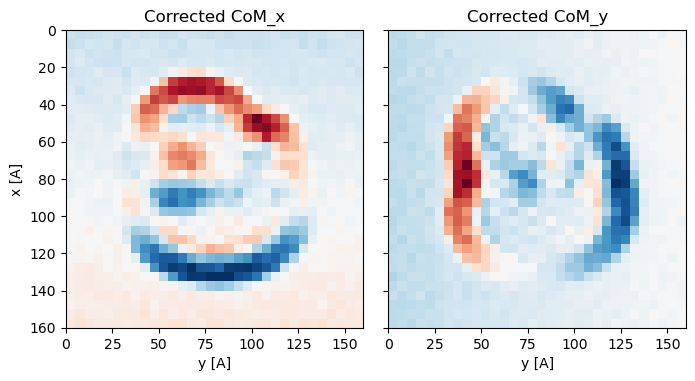

In [8]:
dpc = py4DSTEM.process.phase.DPCReconstruction(
    datacube=dataset,
    energy=80e3,
).preprocess()

Next we perform the DPC reconstruction:

Reconstructing phase:  84%|███████████████████████████████████▍      | 27/32 [00:00<00:00, 3160.04 iter/s]
/home/gvarnavides/SoftwareHub/py4DSTEM/py4DSTEM/process/phase/iterative_dpc.py:796: UserWarning: Step-size has decreased below stopping criterion 1e-06.
  warnings.warn(


Iteration 8, step reduced to 0.25
Iteration 9, step reduced to 0.125
Iteration 10, step reduced to 0.0625
Iteration 11, step reduced to 0.03125
Iteration 12, step reduced to 0.015625
Iteration 13, step reduced to 0.0078125
Iteration 14, step reduced to 0.00390625
Iteration 15, step reduced to 0.001953125
Iteration 16, step reduced to 0.0009765625
Iteration 17, step reduced to 0.00048828125
Iteration 18, step reduced to 0.000244140625
Iteration 19, step reduced to 0.0001220703125
Iteration 20, step reduced to 6.103515625e-05
Iteration 21, step reduced to 3.0517578125e-05
Iteration 22, step reduced to 1.52587890625e-05
Iteration 23, step reduced to 7.62939453125e-06
Iteration 24, step reduced to 3.814697265625e-06
Iteration 25, step reduced to 1.9073486328125e-06
Iteration 26, step reduced to 9.5367431640625e-07


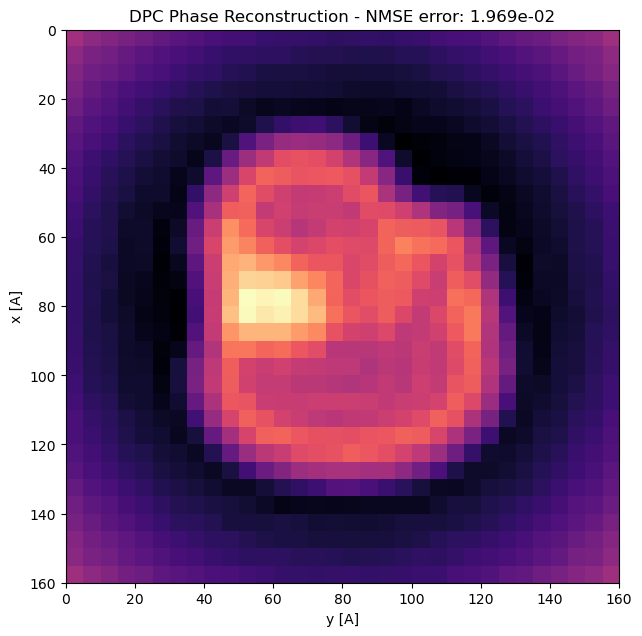

In [9]:
dpc = dpc.reconstruct(
    progress_bar=True,
    store_iterations=True,
    max_iter=32
).visualize()

The reconsruction clearly shows the object on the substrate. However, the resolution is limited to the STEM probe sampling - we only recover one phase value per probe position. In order to perform superresolution imaging (i.e. recover spatial frequencies outside of the numerical aperture / probe semiangle), we will need to peform a ptychographic reconstruction.

# Ptychography

We perform similar pre-processing for ptychography as we do for DPC.  
Getting a good guess for the rotation between real space and diffraction space is essential to getting a good reconstruction in defocused probe ptychography.

Best fit rotation = -15 degrees.
No need to transpose diffraction intensities.


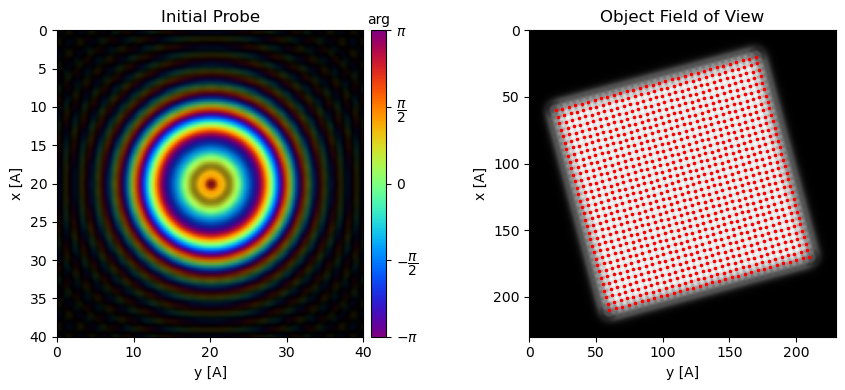

In [10]:
ptycho = py4DSTEM.process.phase.SingleslicePtychographicReconstruction(
    datacube=dataset,
    verbose=True,
    energy=80e3,
    defocus=600,
    vacuum_probe_intensity = probe.data,
    #device='gpu',
).preprocess(
    plot_center_of_mass = False,
    plot_rotation = False,
    plot_probe_overlaps = True,
)

Next, we perform the ptychographic reconstruction.  
There are various options we can tune below, but this reconstruction converges quite rapidly due to the sample being close to a weak phase object (the thickest region of the sample consists of 4 graphene layers).

Performing 8 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 0.1.


Reconstructing object and probe: 100%|███████████████████████████████████| 8/8 [01:07<00:00,  8.48s/ iter]


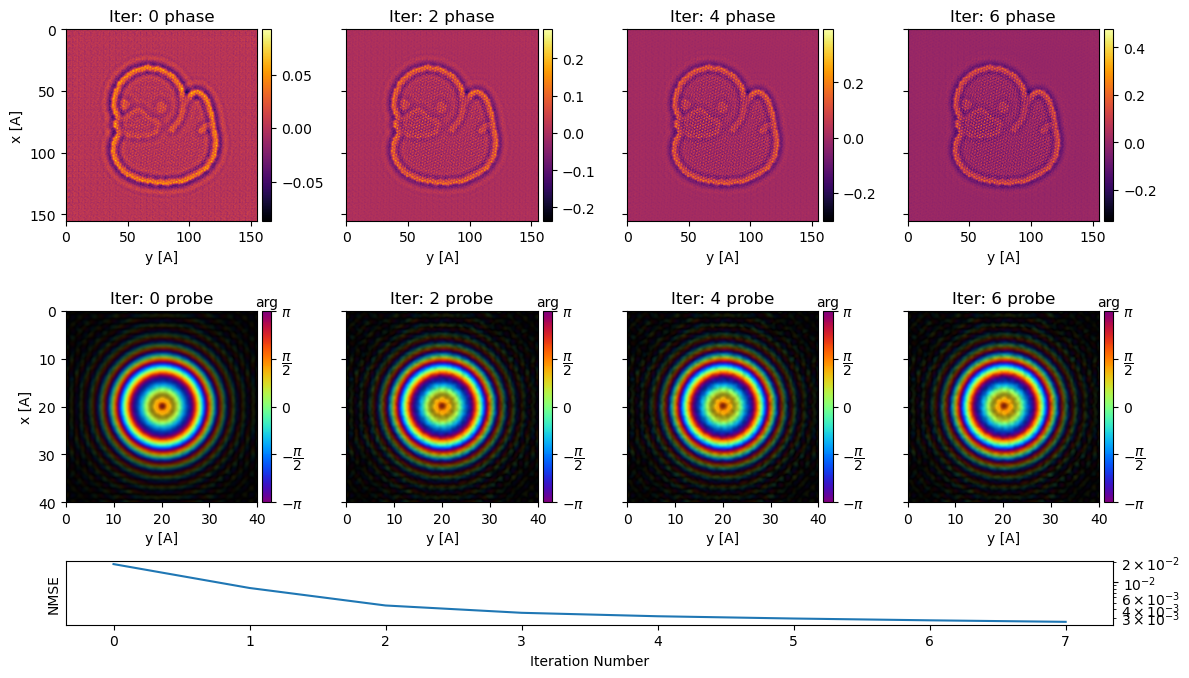

In [11]:
ptycho = ptycho.reconstruct(
    progress_bar = True,
    store_iterations = True,
    max_iter = 8,
    normalization_min=0.1
).visualize(
    cbar=True,
    iterations_grid='auto',
)

We then plot the final reconstructed phase:

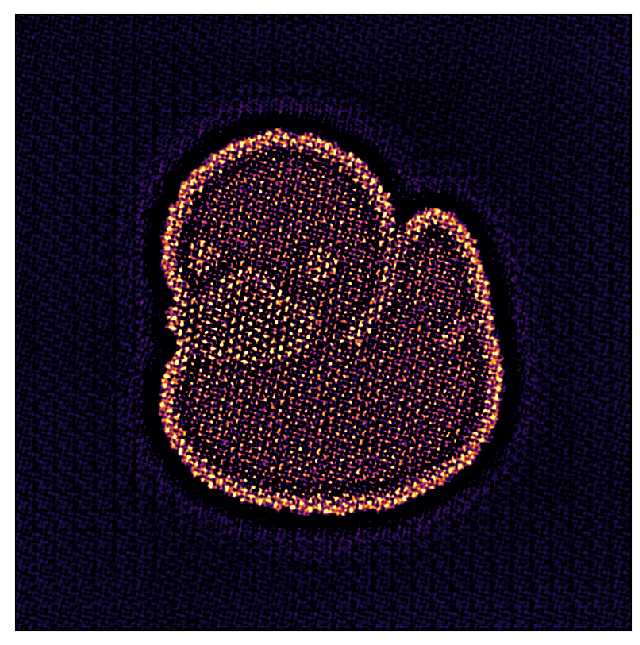

In [12]:
py4DSTEM.show(
    np.angle(ptycho.object_cropped),
    vmin=0.33,
    vmax=0.99,
    cmap='inferno',
    ticks=False,
)